## ```ROBUSTNESS ```

In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import multi_agents_tools  as mat
import pandas as pd
import numpy as np
import json
import seaborn as sns 
import matplotlib.pyplot as plt
from collections import defaultdict
print(tf.__version__)


2.20.0


### ```TESTS```

In [ ]:
# Script de test
name_data='mnist'
x_train, y_train, x_test, y_test = mat.get_data(name_data)
print(f"1. get_data: {y_train.dtype}")  # int32

groups_x, groups_y = mat.split_dataset_fully_synchronized(x_train, y_train, num_groups=3)
print(f"2. split: {groups_y[0].dtype}")  # int32

train_datasets = mat.make_tf_datasets_from_groups(groups_x, groups_y, batch_size=100)
for x, y in train_datasets[0].take(1):
    print(f"3. dataset: {y.dtype}")  # devrait être int32

del groups_x,groups_y


1. get_data: int32
2. split: int32
3. dataset: <dtype: 'int32'>


In [3]:
# Test dans cross_information
multi_agent = mat.MultiAgentAI(k=3)
for batches in zip(*train_datasets):
    x_batch_list = [b[0] for b in batches]
    y_batch_list = [b[1] for b in batches]
    print(f"4. batch labels: {y_batch_list[0].dtype}")  # int32
    losses, outputs = multi_agent.train_step_batch(x_batch_list, y_batch_list)
    print(f"5. Entraînement OK!")
    break
del losses,outputs,train_datasets

✓ CPU détecté - Optimisateur: ADAMW
4. batch labels: <dtype: 'int32'>
5. Entraînement OK!


```TRAIN MULTI AGENTS```

In [4]:
K=7
batch_size=100
input_dim = 784
hidden_dim = K*150
output_dim = 10
lr = 0.001
epochs = 10
verbose=False

In [5]:
train_groups_x, train_groups_y = mat.split_dataset_fully_synchronized(x_train, y_train,num_groups=K)
test_groups_x, test_groups_y = mat.split_dataset_fully_synchronized(x_test, y_test,num_groups=K)

In [6]:
train_datasets = mat.make_tf_datasets_from_groups(train_groups_x, train_groups_y, batch_size=batch_size, shuffle=False)
test_datasets = mat.make_tf_datasets_from_groups(test_groups_x, test_groups_y, batch_size=batch_size, shuffle=False)


In [7]:
mat.verify_batch_synchronization(train_datasets)

True

In [8]:
model=mat.MultiAgentAI(k=K, hidden_size=int(hidden_dim/K), lr=lr, input_shape=(32,32,3),num_classes=10,  optimizer_type='adamw',batch_size=batch_size)

✓ CPU détecté - Optimisateur: ADAMW


In [9]:
history=model.train_step(train_datasets=train_datasets,epochs=epochs, test_datasets=test_datasets,strategy='majority',verbose=True,alpha=1, beta=5)


Epoch 1/10
  Agent 1 - Loss: 29.1850, Acc: 0.1018
  Agent 2 - Loss: 52.1935, Acc: 0.1013
  Agent 3 - Loss: 23.7943, Acc: 0.1053
  Agent 4 - Loss: 55.4591, Acc: 0.1017
  Agent 5 - Loss: 32.7446, Acc: 0.1024
  Agent 6 - Loss: 28.1743, Acc: 0.1018
  Agent 7 - Loss: 58.4121, Acc: 0.1007
  Ensemble Test Accuracy: 0.1000

Epoch 2/10
  Agent 1 - Loss: 9.5841, Acc: 0.1040
  Agent 2 - Loss: 15.1023, Acc: 0.1001
  Agent 3 - Loss: 9.5289, Acc: 0.1010
  Agent 4 - Loss: 10.0821, Acc: 0.1014
  Agent 5 - Loss: 10.3400, Acc: 0.1000
  Agent 6 - Loss: 9.9595, Acc: 0.1004
  Agent 7 - Loss: 15.2275, Acc: 0.1011
  Ensemble Test Accuracy: 0.1000

Epoch 3/10
  Agent 1 - Loss: 7.8841, Acc: 0.1088
  Agent 2 - Loss: 8.3244, Acc: 0.1013
  Agent 3 - Loss: 7.8197, Acc: 0.1021
  Agent 4 - Loss: 7.9290, Acc: 0.1046
  Agent 5 - Loss: 8.6961, Acc: 0.1004
  Agent 6 - Loss: 8.2307, Acc: 0.1026
  Agent 7 - Loss: 8.0396, Acc: 0.1063
  Ensemble Test Accuracy: 0.1000

Epoch 4/10
  Agent 1 - Loss: 7.5277, Acc: 0.1115
  Agen

In [10]:
accuracy=model.evaluate_ensemble(test_datasets,strategy='majority',verbose=True)


Evaluation des agents :
  Agent 1 - Acc: 0.1528
  Agent 2 - Acc: 0.1746
  Agent 3 - Acc: 0.1542
  Agent 4 - Acc: 0.1465
  Agent 5 - Acc: 0.1521
  Agent 6 - Acc: 0.1331
  Agent 7 - Acc: 0.1789
  Ensemble (majority) - Acc: 0.1049


In [11]:
entropies = model.entropy_ensemble(test_datasets)

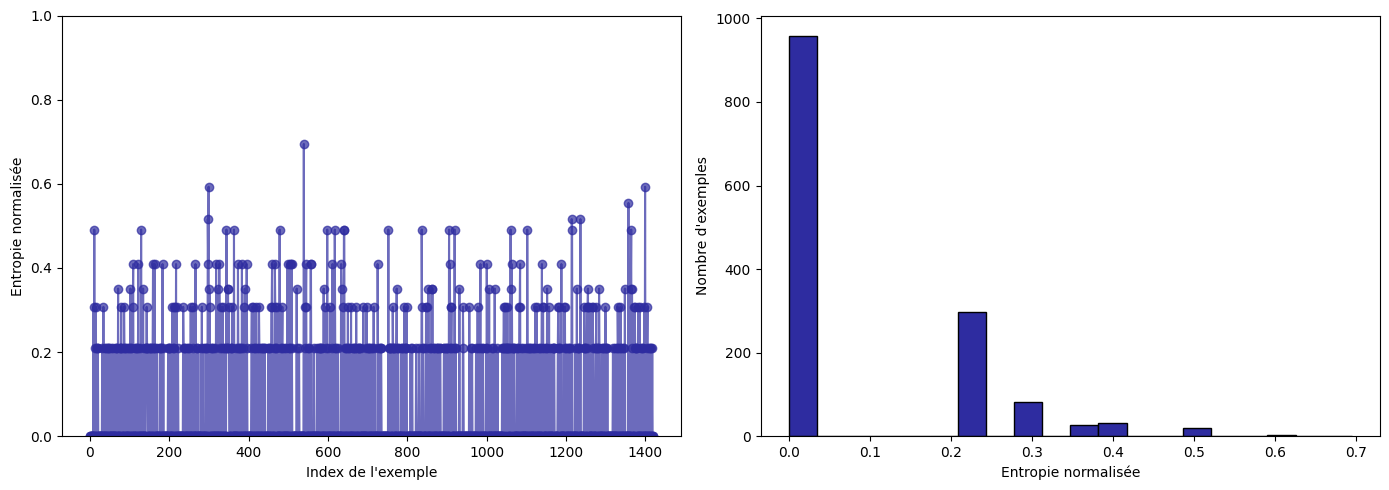

In [12]:
colors = ["#b4821f", "#155D26", "#2e2ca0", "#5f2e2e", "#9467bd"]
inv=0 if name_data in ['mnist'] else 1 if name_data in ['fashion_mnist'] else 2
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Ligne des entropies par exemple
axes[0].plot(entropies, marker='o', linestyle='-', alpha=0.7, color=colors[inv])
# axes[0].set_title("Entropie des prédictions par exemple")
axes[0].set_xlabel("Index de l'exemple")
axes[0].set_ylabel("Entropie normalisée")
axes[0].set_ylim(0, 1)
axes[0].grid(False)

# 2. Histogramme pour la distribution
axes[1].hist(entropies, bins=20, color=colors[inv], edgecolor='black')
# axes[1].set_title("Distribution des entropies")
axes[1].set_xlabel("Entropie normalisée")
axes[1].set_ylabel("Nombre d'exemples")
axes[1].grid(False)

plt.tight_layout()
# plt.savefig(f"Entropie_{name_data}.pdf", dpi=250, bbox_inches="tight")
plt.show()


In [13]:
from collections import Counter
def count_values(tensor):
    """
    Compte le nombre d'occurrences de chaque valeur dans un tenseur 1D.
    Retourne un dictionnaire {valeur: occurrences}.
    """
    x = tf.reshape(tensor, [-1]).numpy()  # flatten + numpy
    counts = Counter(x.tolist())
    return dict(counts)

In [14]:
count_values(entropies)

{-0.0: 959,
 0.3074497580528259: 82,
 0.49113258719444275: 14,
 0.21075810492038727: 297,
 0.3509453237056732: 26,
 0.4092232584953308: 32,
 0.516078531742096: 3,
 0.59290611743927: 2,
 0.49113261699676514: 3,
 0.6946795582771301: 1,
 0.5544922947883606: 1}

In [15]:
entropies.shape

TensorShape([1420])

In [16]:
index={'epochs': [k for k in range(epochs)]}
losses={f'lossAI-{i}':history.get('losses')[i] for i in range(K)}
accuracies={f'accuracyAI-{i}': history.get('accuracies')[i] for i in range(K)}
ensemble_accuracy={f'majority': history.get('ensemble_accuracy')}

In [17]:
json_=defaultdict()

In [18]:
json_.update(index)
json_.update(losses)
json_.update(accuracies)
json_.update(ensemble_accuracy)

In [19]:
df=pd.DataFrame(json_)
df.set_index('epochs', inplace=True)

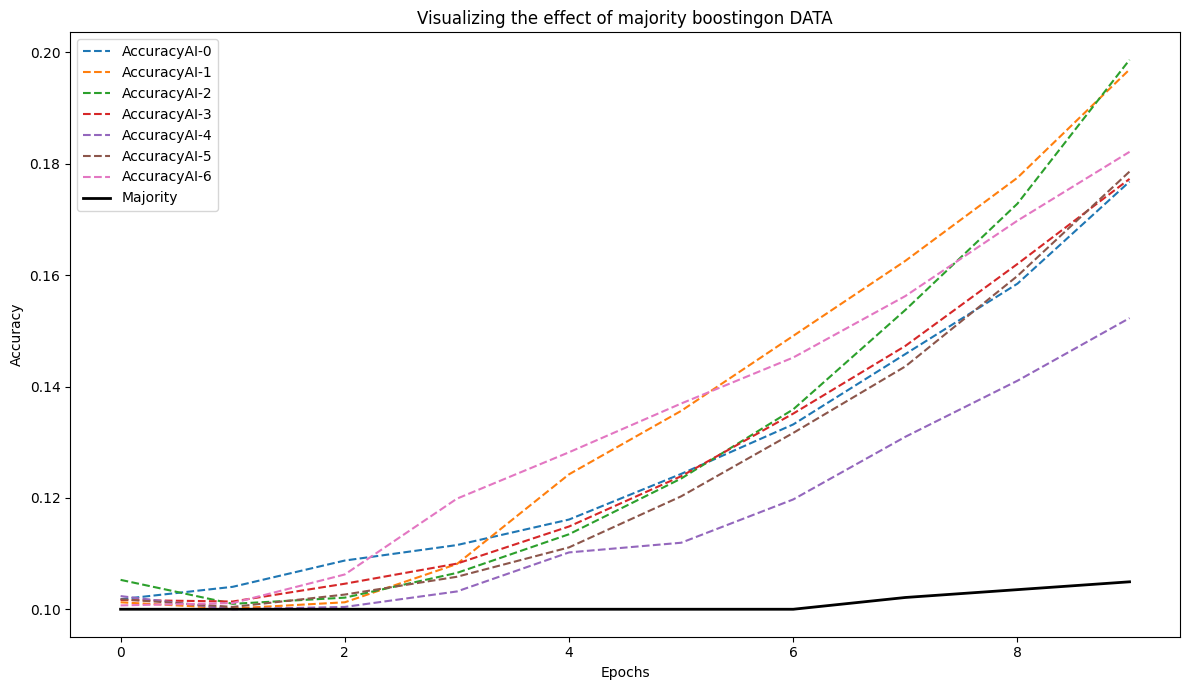

In [20]:
plt.figure(figsize=(12, 7))
# Tracer les précisions
for i in range(K):
    plt.plot(df.index, df[f'accuracyAI-{i}'], label=f'AccuracyAI-{i}', linestyle='--')

# Tracer la précision majoritaire
plt.plot(df.index, df['majority'], label='Majority', color='black', linewidth=2)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Visualizing the effect of majority boostingon DATA')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig(f"majority_boosting_fashion_mnist.pdf", dpi=300, bbox_inches="tight")
plt.show()

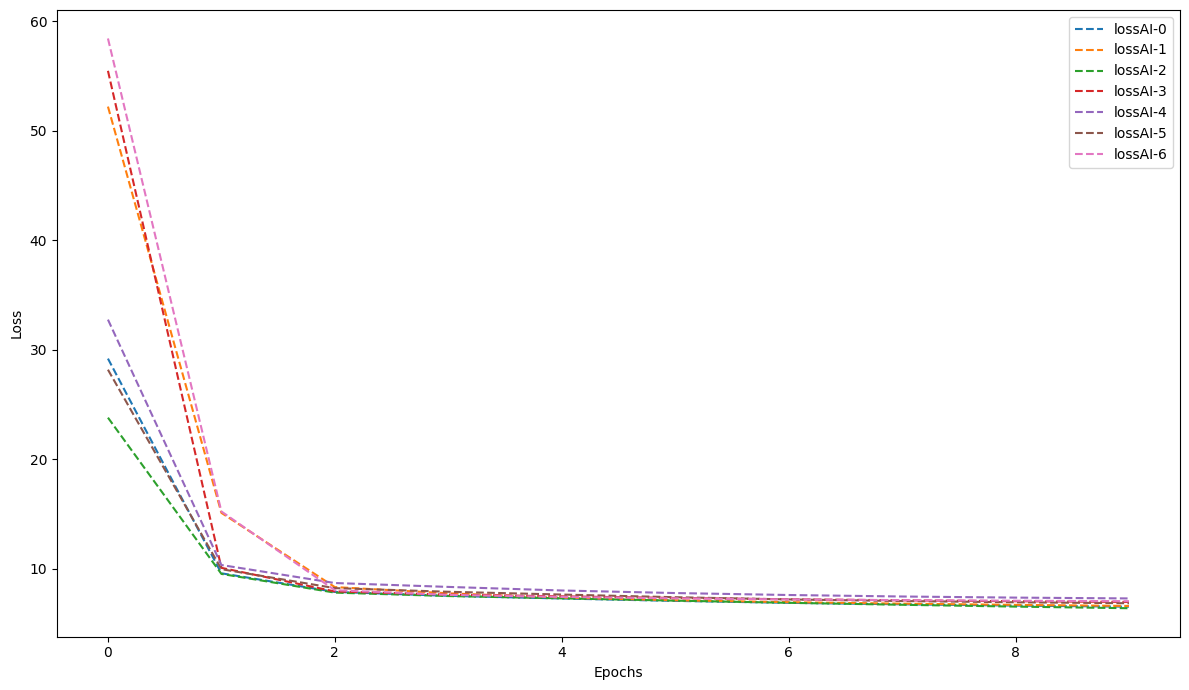

In [21]:
plt.figure(figsize=(12, 7))
# Tracer les précisions
for i in range(K):
    plt.plot(df.index, df[f'lossAI-{i}'], label=f'lossAI-{i}', linestyle='--')


plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig(f"majoprity_boosting_losses.pdf", dpi=300, bbox_inches="tight")
plt.show()


In [22]:
with open("historique.json", "w") as f:
    json.dump(json_, f, indent=4)


```TRAIN STANDARD```